In [1]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import numpy as np

import tensorflow as tf
import keras, datetime
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.xception import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from keras.applications import xception
from keras.regularizers import l1, l2

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../')
from input.mydataset.cyclicLR import CyclicLR

import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, axis, show
 
import matplotlib.image as mpimg

import numpy as np 
import pandas as pd 

from math import ceil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime, date

from keras.models import load_model
import cv2
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../input/mydataset/Earthquakes.csv")

In [4]:
def split_date(date_string):
  return date_string.split(' ')

In [5]:
dates = []
times = []
for i in range(len(df)):
  cur_date, cur_time = split_date(df.loc[i].iloc[1])
  dates.append(cur_date)
  times.append(cur_time)
dates = pd.Series(dates)
times = pd.Series(times)

In [6]:
df.insert(1, 'Date', dates, allow_duplicates = True)
df.insert(2, 'Time', times, allow_duplicates = True)
df.drop(columns = 'Date(UTC)', inplace = True)

In [7]:
df = df.sort_values(['Date', 'Time'], ascending=[True, True])
df= df.reset_index(drop=True)

In [8]:
def calculate_days(date_string_1, date_string_2):

  date_1 = datetime.strptime(date_string_1, '%Y-%m-%d')
  date_2 = datetime.strptime(date_string_2, '%Y-%m-%d')

  d1=date(year = date_1.year, month = date_1.month, day = date_1.day)
  d2=date(year = date_2.year, month = date_2.month, day = date_2.day)

  return (d1 - d2).days

In [9]:
def time_in_hours(date_string):
  
  date_num = datetime.strptime(date_string, '%H:%M:%S')

  hr=((date_num.hour * 60) + date_num.minute) / (24 * 60)

  return hr

In [10]:
begin_date = '1900-01-01'
df['Time gap'] = ""
df['Converted Date'] = ""
df['Converted Time'] = ""
df['Converted Date'].loc[0] = calculate_days(df['Date'][0], begin_date)
df['Time gap'].loc[0] = 0
df['Converted Time'].loc[0] = time_in_hours(df['Time'].loc[0])
for i in range (1, len(df['Date'])):
  df['Time gap'].loc[i] = calculate_days(df['Date'][i], df['Date'][i - 1])
  df['Converted Date'].loc[i] = calculate_days(df['Date'][i], begin_date)
  df['Converted Time'].loc[i] = time_in_hours(df['Time'][i])
df.drop(columns = ['Date', 'Time'], inplace=True)

In [11]:
df['Converted Time'] = pd.to_numeric(df['Converted Time'])

In [12]:
df['Constant Deg.'] = df['Constant Deg.'].replace({'No' : 0, 'Yes' : 1})

In [13]:
df = df.rename(columns={"Constant Deg.": "ConstantDeg"})

In [14]:
df.drop(columns=['No', 'Ref1', 'Source Description 1', 'Source No 2',
                'Source Description 2', 'Source No 3', 'Source Description 3',
                'Type'], inplace = True)

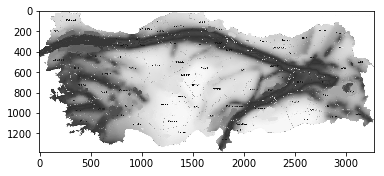

In [15]:
img=cv2.imread("../input/mydataset/risk_map_clean.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

(<matplotlib.image.AxesImage at 0x7fd48370d2b0>, Text(0.5, 1.0, 'Blurred'))

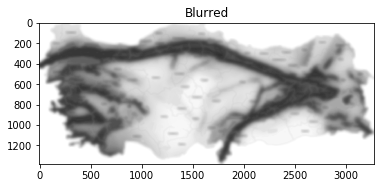

In [16]:
blur = cv2.GaussianBlur(img,(7,7),0)
for i in range(105):
  blur = cv2.GaussianBlur(blur,(7,7),0)
plt.imshow(blur, cmap='gray', vmin=0, vmax=255),plt.title('Blurred')

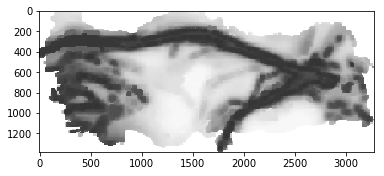

In [17]:
size=6
increment=2
epoch=4
# recovered_img=blur.copy()
recovered_img = img.copy()

for i in range(0,epoch):
  
  width_step=np.shape(recovered_img)[1]/size
  height_step=np.shape(recovered_img)[0]/size

  for h in range(0, int(height_step)):
    for w in range(0, int(width_step)):

      window = recovered_img[h * size:(h + 1) * size, w * size:(w + 1) * size]
      if i == 0:
        window = window.max()
      else:
        window = window.min()

      recovered_img[h * size:(h + 1) * size, w * size:(w + 1) * size] = window

  size += increment
plt.imshow(recovered_img, cmap='gray', vmin=0, vmax=255)

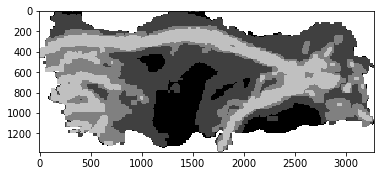

In [18]:
risk_map = recovered_img.copy()

high=75
medium=150
low=225
no_data=250
default=5

risk_map=np.where(risk_map<=high, 4, risk_map)
risk_map=np.where(((risk_map>high) & (risk_map<=medium)), 3, risk_map)
risk_map=np.where(((risk_map>medium) & (risk_map<=low)), 2, risk_map)
risk_map=np.where(((risk_map>low) & (risk_map<=no_data)), 1, risk_map)
risk_map=np.where(risk_map>no_data, default, risk_map)
plt.imshow(risk_map, cmap='gray', vmin=1, vmax=5)

In [19]:
def risk(latitude, longitude):
  
  west=25.67
  east=44.81
  south=35.81
  north=42.10

  real_width = east - west
  real_height = north - south

  map_width = np.shape(risk_map)[1]
  map_height = np.shape(risk_map)[0]

  width_ratio = map_width/(real_width*100)
  height_ratio = map_height/(real_height*100)

  # Calculating pixels to look up for the grade
  easting = longitude-west
  northing = latitude-south

  pixel_x = int(round(easting*100*width_ratio))
  pixel_y = map_height-int(round(northing*100*height_ratio))

  # Correction of the error caused by floating points
  if pixel_x >= map_width:
    pixel_x = map_width-1

  if pixel_y >= map_height:
    pixel_y = map_height-1
  
  grade=risk_map[pixel_y, pixel_x]

  return grade

In [20]:
grades = []
for i in range(len(df)):
  grades.append(risk(df.loc[i].iloc[0], df.loc[i].iloc[1]))
df['Risk Grade']=pd.Series(grades)

In [21]:
df.head()

,Latitude,Longitude,Depth,ConstantDeg,Magnitude,Time gap,Converted Date,Converted Time,Risk Grade
0,37.79,28.21,10.0,1,4.4,0,17,0.645833,4
1,39.54,26.14,10.0,1,5.2,6,23,0.125000,3
2,37.63,37.37,10.0,1,4.8,3,26,0.104167,4
3,37.83,27.71,10.0,1,4.4,3,29,0.041667,4
4,38.12,31.29,10.0,1,5.7,7,36,0.631250,3


**LSTM**

In [167]:
cols = list(df.columns.values)
cols

['Latitude',
 'Longitude',
 'Depth',
 'ConstantDeg',
 'Magnitude',
 'Time gap',
 'Converted Date',
 'Converted Time',
 'Risk Grade']

In [204]:
input_data = sc.fit_transform(df[[
'Latitude',
'Longitude',
'Magnitude',
'Converted Date',
'Depth',
'ConstantDeg',
'Time gap',
'Converted Time',
'Risk Grade']])
input_data = np.array(input_data)

In [205]:
lookback = 20

In [206]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [207]:
y = input_data[lookback:, 0:4]
y = scaler_y.fit_transform(y)

In [210]:
input_data = scaler_x.fit_transform(input_data)

In [211]:
X = []
for i in range(len(df)-lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)

In [212]:
X = np.array(X)
X = X.reshape(X.shape[0], lookback, 9)

In [221]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [245]:
model = Sequential()
model.add(LSTM(30, activation='relu', input_shape=(20, 9)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4))

In [246]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])

In [247]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), verbose=1, shuffle=True)

Train on 4194 samples, validate on 1049 samples
Epoch 1/200
4194/4194 [==============================] - 2s 593us/step - loss: 0.4430 - accuracy: 0.3648 - mae: 0.4900 - val_loss: 0.0709 - val_accuracy: 0.6587 - val_mae: 0.2088
Epoch 2/200
4194/4194 [==============================] - 2s 377us/step - loss: 0.0962 - accuracy: 0.5587 - mae: 0.2458 - val_loss: 0.0590 - val_accuracy: 0.7102 - val_mae: 0.1920
Epoch 3/200
4194/4194 [==============================] - 2s 383us/step - loss: 0.0683 - accuracy: 0.6805 - mae: 0.2046 - val_loss: 0.0555 - val_accuracy: 0.7102 - val_mae: 0.1894
Epoch 4/200
4194/4194 [==============================] - 2s 390us/step - loss: 0.0585 - accuracy: 0.7246 - mae: 0.1885 - val_loss: 0.0518 - val_accuracy: 0.7178 - val_mae: 0.1824
Epoch 5/200
4194/4194 [==============================] - 2s 377us/step - loss: 0.0547 - accuracy: 0.7325 - mae: 0.1825 - val_loss: 0.0488 - val_accuracy: 0.7369 - val_mae: 0.1765
Epoch 6/200
4194/4194 [==============================] - 

4194/4194 [==============================] - 2s 379us/step - loss: 0.0446 - accuracy: 0.7582 - mae: 0.1577 - val_loss: 0.0402 - val_accuracy: 0.7684 - val_mae: 0.1495
Epoch 47/200
4194/4194 [==============================] - 2s 381us/step - loss: 0.0442 - accuracy: 0.7489 - mae: 0.1572 - val_loss: 0.0389 - val_accuracy: 0.7712 - val_mae: 0.1441
Epoch 48/200
4194/4194 [==============================] - 2s 396us/step - loss: 0.0442 - accuracy: 0.7506 - mae: 0.1567 - val_loss: 0.0395 - val_accuracy: 0.7750 - val_mae: 0.1475
Epoch 49/200
4194/4194 [==============================] - 2s 385us/step - loss: 0.0444 - accuracy: 0.7532 - mae: 0.1573 - val_loss: 0.0396 - val_accuracy: 0.7712 - val_mae: 0.1460
Epoch 50/200
4194/4194 [==============================] - 2s 379us/step - loss: 0.0445 - accuracy: 0.7477 - mae: 0.1576 - val_loss: 0.0393 - val_accuracy: 0.7674 - val_mae: 0.1449
Epoch 51/200
4194/4194 [==============================] - 2s 382us/step - loss: 0.0437 - accuracy: 0.7492 - mae: 

4194/4194 [==============================] - 2s 381us/step - loss: 0.0431 - accuracy: 0.7577 - mae: 0.1544 - val_loss: 0.0384 - val_accuracy: 0.7750 - val_mae: 0.1417
Epoch 92/200
4194/4194 [==============================] - 2s 386us/step - loss: 0.0433 - accuracy: 0.7608 - mae: 0.1549 - val_loss: 0.0381 - val_accuracy: 0.7741 - val_mae: 0.1389
Epoch 93/200
4194/4194 [==============================] - 2s 394us/step - loss: 0.0427 - accuracy: 0.7546 - mae: 0.1534 - val_loss: 0.0378 - val_accuracy: 0.7779 - val_mae: 0.1384
Epoch 94/200
4194/4194 [==============================] - 2s 380us/step - loss: 0.0430 - accuracy: 0.7530 - mae: 0.1535 - val_loss: 0.0385 - val_accuracy: 0.7750 - val_mae: 0.1427
Epoch 95/200
4194/4194 [==============================] - 2s 385us/step - loss: 0.0436 - accuracy: 0.7508 - mae: 0.1550 - val_loss: 0.0377 - val_accuracy: 0.7741 - val_mae: 0.1375
Epoch 96/200
4194/4194 [==============================] - 2s 387us/step - loss: 0.0426 - accuracy: 0.7487 - mae: 

4194/4194 [==============================] - 2s 391us/step - loss: 0.0420 - accuracy: 0.7580 - mae: 0.1511 - val_loss: 0.0378 - val_accuracy: 0.7779 - val_mae: 0.1383
Epoch 137/200
4194/4194 [==============================] - 2s 398us/step - loss: 0.0421 - accuracy: 0.7594 - mae: 0.1512 - val_loss: 0.0378 - val_accuracy: 0.7779 - val_mae: 0.1377
Epoch 138/200
4194/4194 [==============================] - 2s 390us/step - loss: 0.0422 - accuracy: 0.7570 - mae: 0.1519 - val_loss: 0.0376 - val_accuracy: 0.7807 - val_mae: 0.1390
Epoch 139/200
4194/4194 [==============================] - 2s 396us/step - loss: 0.0424 - accuracy: 0.7563 - mae: 0.1513 - val_loss: 0.0380 - val_accuracy: 0.7769 - val_mae: 0.1381
Epoch 140/200
4194/4194 [==============================] - 2s 391us/step - loss: 0.0424 - accuracy: 0.7582 - mae: 0.1517 - val_loss: 0.0376 - val_accuracy: 0.7836 - val_mae: 0.1378
Epoch 141/200
4194/4194 [==============================] - 2s 399us/step - loss: 0.0419 - accuracy: 0.7558 - 

4194/4194 [==============================] - 2s 399us/step - loss: 0.0420 - accuracy: 0.7580 - mae: 0.1514 - val_loss: 0.0386 - val_accuracy: 0.7817 - val_mae: 0.1406
Epoch 182/200
4194/4194 [==============================] - 2s 391us/step - loss: 0.0416 - accuracy: 0.7628 - mae: 0.1504 - val_loss: 0.0379 - val_accuracy: 0.7798 - val_mae: 0.1379
Epoch 183/200
4194/4194 [==============================] - 2s 402us/step - loss: 0.0418 - accuracy: 0.7587 - mae: 0.1514 - val_loss: 0.0383 - val_accuracy: 0.7788 - val_mae: 0.1390
Epoch 184/200
4194/4194 [==============================] - 2s 418us/step - loss: 0.0413 - accuracy: 0.7601 - mae: 0.1497 - val_loss: 0.0381 - val_accuracy: 0.7722 - val_mae: 0.1388
Epoch 185/200
4194/4194 [==============================] - 2s 382us/step - loss: 0.0415 - accuracy: 0.7599 - mae: 0.1502 - val_loss: 0.0377 - val_accuracy: 0.7817 - val_mae: 0.1366
Epoch 186/200
4194/4194 [==============================] - 2s 408us/step - loss: 0.0416 - accuracy: 0.7525 - 

In [256]:
history.history['accuracy']

AttributeError: 'list' object has no attribute 'mean'

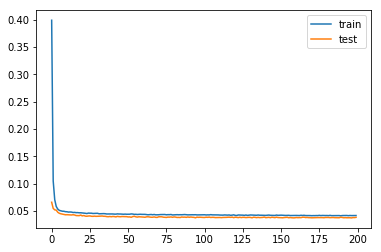

In [226]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [230]:
prediction = model.predict(x_test)
prediction = scaler_y.inverse_transform(prediction)
answers = scaler_y.inverse_transform(y_test)

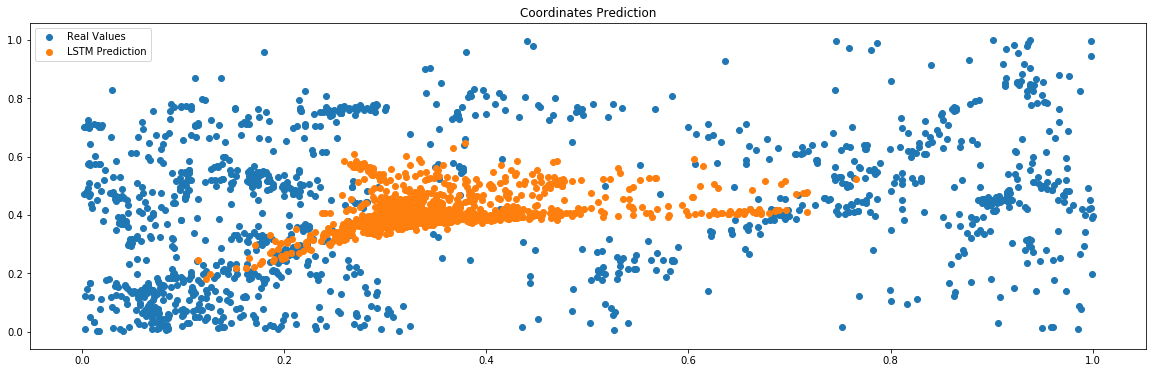

In [235]:
plt.figure(figsize=(20,6))
plt.scatter(answers.T[1], answers.T[0], label="Real Values")
plt.scatter(prediction.T[1], prediction.T[0], label="LSTM Prediction")
plt.title("Coordinates Prediction")
plt.legend()
plt.show()

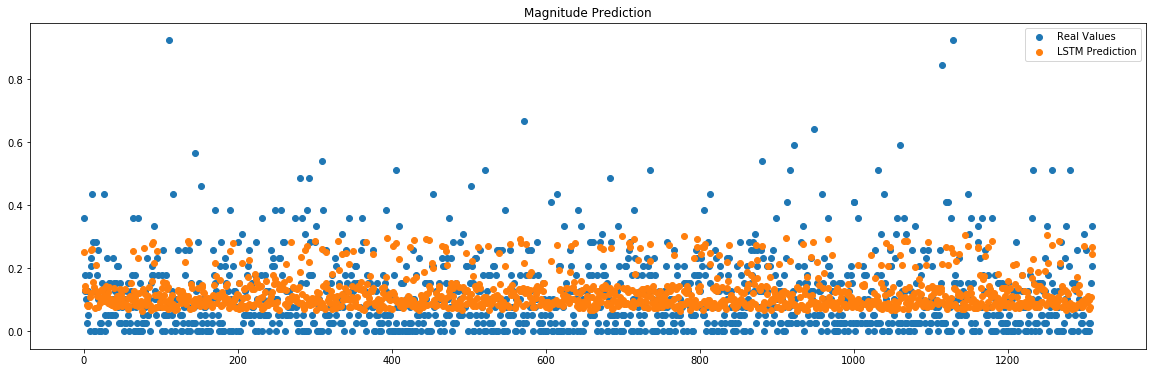

In [240]:
ind=[i for i in range(0, len(answers))]

plt.figure(figsize=(20,6))
plt.scatter(ind, answers.T[2], label="Real Values")
plt.scatter(ind, prediction.T[2], label="LSTM Prediction")
plt.title("Magnitude Prediction")
plt.legend()
plt.show()

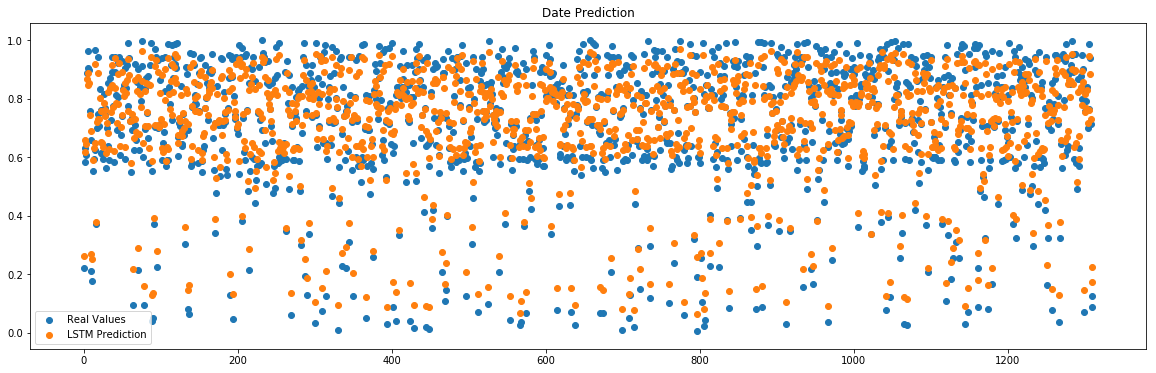

In [242]:
ind=[i for i in range(0, len(answers))]

plt.figure(figsize=(20,6))
plt.scatter(ind, answers.T[3], label="Real Values")
plt.scatter(ind, prediction.T[3], label="LSTM Prediction")
plt.title("Date Prediction")
plt.legend()
plt.show()